In [20]:
# install some libraries 
!pip install scienceplots --quiet
!pip install yfinance --quiet
!pip install linearmodels --quiet
!pip install stargazer --quiet

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import glob
import scienceplots
import yfinance as yf

# graph style 
plt.style.use(['science', 'notebook', 'grid'])

# Stock market data

In [22]:
# getting the G7 stock market data
tickers = ['^GSPC','^GSPTSE', '^FTSE', '^FCHI', 'FTSEMIB.MI', '^GDAXI', '^N225']
df_sm = yf.download(tickers = tickers, start = "2000-01-01", end = "2022-12-31")
df_sm = df_sm.Close

# reframing the date for use
all_days = pd.date_range(start = "2000-01-01", end = "2022-12-31", freq ="D")
df_sm = df_sm.reindex(all_days)
df_sm = df_sm.fillna(method = 'ffill').dropna()
df_sm.columns = df_sm.columns.str.replace('^','').str.strip()
df_sm = df_sm.rename(columns = {'FTSEMIB.MI':'ITA', 'FCHI':'FRA', 'FTSE': 'GBR', 'GDAXI': 'DEU', 'GSPC':'USA', 'GSPTSE':'CAN','N225':'JPN'})
df_sm = df_sm.rename_axis('Date')
# g7_avg_ind = df_sm.mean(axis =1)
# df_sm['G7 INDEX'] = g7_avg_ind

df_sm.head()

# np.log(df_sm).plot()
# plt.grid(visible=None)

[*********************100%%**********************]  7 of 7 completed


Ticker,ITA,FRA,GBR,DEU,USA,CAN,JPN
Date,,,,,,,
2000-01-04,40314.0,5672.020020,6665.899902,6586.950195,1399.420044,8202.599609,19002.859375
2000-01-05,39452.0,5479.700195,6535.899902,6502.069824,1402.109985,8119.399902,18542.550781
2000-01-06,38835.0,5450.109863,6447.200195,6474.919922,1403.449951,8114.200195,18168.269531
2000-01-07,40194.0,5539.609863,6504.799805,6780.959961,1441.469971,8429.400391,18193.410156
2000-01-08,40194.0,5539.609863,6504.799805,6780.959961,1441.469971,8429.400391,18193.410156


In [23]:
# index values for df
df_sm_index = df_sm.resample('Y').mean()
df_sm_index['date'] = df_sm_index.index
df_sm_index = pd.melt(df_sm_index, id_vars=['date'], var_name = 'location', value_name = 'stock_index')
df_sm_index = df_sm_index.sort_values(by = ['location','date']).set_index('date')
df_sm_index.head()

,location,stock_index
date,,
2000-12-31,CAN,9704.092560
2001-12-31,CAN,7775.645209
2002-12-31,CAN,7054.353402
2003-12-31,CAN,7124.198360
2004-12-31,CAN,8597.862597


In [24]:
# calculate the returns
df_sm_returns = np.log(df_sm.div(df_sm.shift(periods = 1))).mul(100).dropna()
df_sm_g7_avg = df_sm_returns.sum(axis=1)
# df_sm_returns['G7 RETURN'] = df_sm_g7_avg
df_sm_returns = df_sm_returns.resample('Y').mean()
df_sm_returns.head()

# df_sm_returns.plot()

Ticker,ITA,FRA,GBR,DEU,USA,CAN,JPN
Date,,,,,,,
2000-12-31,0.022038,0.012120,-0.019015,-0.006507,-0.016081,0.023586,-0.088663
2001-12-31,-0.082434,-0.067955,-0.048266,-0.060433,-0.038288,-0.041128,-0.073481
2002-12-31,-0.087192,-0.112793,-0.076909,-0.158573,-0.072912,-0.041219,-0.056470
2003-12-31,0.036795,0.040953,0.034972,0.086406,0.064144,0.059566,0.059931
2004-12-31,0.038036,0.019504,0.019852,0.019345,0.023529,0.032128,0.020030


In [25]:
# framing as the panels of green vars
df_returns = df_sm_returns.copy()
df_returns['date'] = df_returns.index
df_returns = pd.melt(df_returns, id_vars=['date'], var_name = 'location', value_name = 'stock_returns')
df_returns = df_returns.sort_values(by = ['location','date']).set_index('date')
df_returns.head(4)

,location,stock_returns
date,,
2000-12-31,CAN,0.023586
2001-12-31,CAN,-0.041128
2002-12-31,CAN,-0.041219
2003-12-31,CAN,0.059566


# Green Finance Related Variables 

In [26]:
# Wrting the function for data wrangling

def data_prep(filepath):
    df = pd.read_csv(filepath)
    df['DATE'] = pd.to_datetime(df['TIME'], format = '%Y')
    df['DATE'] = df['DATE'] + pd.offsets.YearEnd()
    df.columns = df.columns.str.lower().str.strip()
    df.set_index('date', inplace = True)
    df.drop(columns = ['indicator', 'subject', 'measure', 'frequency', 'time', 'flag codes'], inplace = True)

    return df
# loading the data in a list and concatenate thereby

# creating a list for the csv files
file_list = glob.glob("/kaggle/input/vars-green-oecd/*.csv")

# running the cleaning part
dfs = []

for file in file_list:
    df = data_prep(file)
    dfs.append(df)

# Merge DataFrames based on 'location' and 'date' columns
mdf = pd.concat(dfs).groupby(['date','location']).first().reset_index()
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               184 non-null    datetime64[ns]
 1   location           184 non-null    object        
 2   exprt_pc_gdp       160 non-null    float64       
 3   rec_mill_usd       154 non-null    object        
 4   env_pat_pc_tot     168 non-null    float64       
 5   co2_per_cap        184 non-null    float64       
 6   unr_pc_lf          171 non-null    float64       
 7   ren_en_ktoe        154 non-null    float64       
 8   try_eduexp_pc_gdp  93 non-null     float64       
 9   gni_mln_usd        168 non-null    float64       
 10  co2_mln_tonne      184 non-null    object        
 11  term_trade_rt      160 non-null    float64       
 12  gdp_mln_usd        184 non-null    object        
 13  envtx_pc_gdp       169 non-null    float64       
 14  govt_borr_

In [27]:
# Removing the necessary columns 
mdf.drop(columns = ['try_eduexp_pc_gdp'], inplace = True)
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              184 non-null    datetime64[ns]
 1   location          184 non-null    object        
 2   exprt_pc_gdp      160 non-null    float64       
 3   rec_mill_usd      154 non-null    object        
 4   env_pat_pc_tot    168 non-null    float64       
 5   co2_per_cap       184 non-null    float64       
 6   unr_pc_lf         171 non-null    float64       
 7   ren_en_ktoe       154 non-null    float64       
 8   gni_mln_usd       168 non-null    float64       
 9   co2_mln_tonne     184 non-null    object        
 10  term_trade_rt     160 non-null    float64       
 11  gdp_mln_usd       184 non-null    object        
 12  envtx_pc_gdp      169 non-null    float64       
 13  govt_borr_pc_gdp  154 non-null    float64       
 14  oilp_usd_bar      154 non-

In [28]:
# except OECD
df_green_vars = mdf[mdf['location'] !='OECD']
# Remove commas and convert to numeric for selected columns
columns_to_convert = ['co2_mln_tonne', 'gdp_mln_usd', 'rec_mill_usd']
for col in columns_to_convert:
    df_green_vars[col] = pd.to_numeric(df_green_vars[col].str.replace(',', ''), errors='coerce')

/tmp/ipykernel_42/3648315247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_green_vars[col] = pd.to_numeric(df_green_vars[col].str.replace(',', ''), errors='coerce')


In [29]:
df_green_vars.isna().sum()
df_green_vars[df_green_vars['env_pat_pc_tot'].isna()].head(7)

,date,location,exprt_pc_gdp,rec_mill_usd,env_pat_pc_tot,co2_per_cap,unr_pc_lf,ren_en_ktoe,gni_mln_usd,co2_mln_tonne,term_trade_rt,gdp_mln_usd,envtx_pc_gdp,govt_borr_pc_gdp,oilp_usd_bar
168,2021-12-31,CAN,30.91,3244.74,NaN,13.22,7.54,46727.1931,2.114343e+06,505.59,112.62,2126695.67,NaN,-4.38,69.44
169,2021-12-31,DEU,47.28,3204.68,NaN,7.50,3.58,45015.9179,5.351645e+06,624.09,99.84,5153144.25,1.60,-3.59,71.19
170,2021-12-31,FRA,30.03,1964.74,NaN,4.28,7.88,27402.1698,3.728408e+06,291.76,100.17,3648082.84,2.28,-6.48,71.70
171,2021-12-31,GBR,29.60,1475.32,NaN,4.75,4.53,20720.8501,3.561497e+06,320.81,99.10,3542061.49,1.99,-7.86,71.20
172,2021-12-31,ITA,32.07,1938.33,NaN,5.24,9.56,27128.5329,2.989175e+06,309.65,100.79,2951508.17,3.05,-8.77,71.45
173,2021-12-31,JPN,18.20,1999.11,NaN,7.95,2.82,28457.1157,5.836941e+06,998.14,96.07,5566714.34,1.27,-6.20,70.25
175,2021-12-31,USA,10.89,10845.36,NaN,13.76,5.37,168327.8326,2.361711e+07,4549.26,107.35,23315081.00,0.62,-12.06,64.43


In [30]:
# Sorting and setting index of the data
df_green_vars = df_green_vars.sort_values(by = ['location','date']).set_index('date')
df_green_vars.tail()

,location,exprt_pc_gdp,rec_mill_usd,env_pat_pc_tot,co2_per_cap,unr_pc_lf,ren_en_ktoe,gni_mln_usd,co2_mln_tonne,term_trade_rt,gdp_mln_usd,envtx_pc_gdp,govt_borr_pc_gdp,oilp_usd_bar
date,,,,,,,,,,,,,,
2018-12-31,USA,12.36,10203.47,10.34,15.02,3.90,172385.0877,20937355.0,4910.38,102.51,20533058.0,0.73,-6.09,59.19
2019-12-31,USA,11.87,9852.08,9.27,14.44,3.67,174899.3197,21764537.0,4744.81,103.68,21380976.0,0.73,-6.66,56.33
2020-12-31,USA,10.20,6285.45,8.74,12.90,8.09,171874.4973,21472360.0,4257.63,103.40,21060474.0,0.65,-14.86,36.57
2021-12-31,USA,10.89,10845.36,NaN,13.76,5.37,168327.8326,23617113.0,4549.26,107.35,23315081.0,0.62,-12.06,64.43
2022-12-31,USA,NaN,NaN,NaN,13.64,NaN,NaN,NaN,4549.59,NaN,25439700.0,NaN,NaN,NaN


In [31]:
# Filling the NA values using the last available data
for country in df_green_vars['location'].unique():
        df_green_vars.loc[df_green_vars['location']==country] = df_green_vars[df_green_vars['location']==country].fillna(method ='ffill')
df_green_vars.tail(3)

,location,exprt_pc_gdp,rec_mill_usd,env_pat_pc_tot,co2_per_cap,unr_pc_lf,ren_en_ktoe,gni_mln_usd,co2_mln_tonne,term_trade_rt,gdp_mln_usd,envtx_pc_gdp,govt_borr_pc_gdp,oilp_usd_bar
date,,,,,,,,,,,,,,
2020-12-31,USA,10.20,6285.45,8.74,12.90,8.09,171874.4973,21472360.0,4257.63,103.40,21060474.0,0.65,-14.86,36.57
2021-12-31,USA,10.89,10845.36,8.74,13.76,5.37,168327.8326,23617113.0,4549.26,107.35,23315081.0,0.62,-12.06,64.43
2022-12-31,USA,10.89,10845.36,8.74,13.64,5.37,168327.8326,23617113.0,4549.59,107.35,25439700.0,0.62,-12.06,64.43


# Merging All Data 

In [32]:
# merging stock returns and the green vars data 
df_all = pd.concat([df_green_vars,df_returns]).groupby(['location','date']).first().reset_index().set_index('date')
df_all = pd.concat([df_all,df_sm_index]).groupby(['location','date']).first().reset_index().set_index('date')
df_all[df_all.isna().any(axis=1)]
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2000-12-31 to 2022-12-31
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   location          161 non-null    object 
 1   exprt_pc_gdp      161 non-null    float64
 2   rec_mill_usd      161 non-null    float64
 3   env_pat_pc_tot    161 non-null    float64
 4   co2_per_cap       161 non-null    float64
 5   unr_pc_lf         161 non-null    float64
 6   ren_en_ktoe       161 non-null    float64
 7   gni_mln_usd       161 non-null    float64
 8   co2_mln_tonne     161 non-null    float64
 9   term_trade_rt     161 non-null    float64
 10  gdp_mln_usd       161 non-null    float64
 11  envtx_pc_gdp      161 non-null    float64
 12  govt_borr_pc_gdp  156 non-null    float64
 13  oilp_usd_bar      161 non-null    float64
 14  stock_returns     161 non-null    float64
 15  stock_index       161 non-null    float64
dtypes: float64(15), object(1)

In [33]:
# back fill the nan values 
df_all[df_all['location']=='JPN'] = df_all[df_all['location']=='JPN'].fillna(method='bfill')
df_all[df_all['location']=='CAN'].head()

,location,exprt_pc_gdp,rec_mill_usd,env_pat_pc_tot,co2_per_cap,unr_pc_lf,ren_en_ktoe,gni_mln_usd,co2_mln_tonne,term_trade_rt,gdp_mln_usd,envtx_pc_gdp,govt_borr_pc_gdp,oilp_usd_bar,stock_returns,stock_index
date,,,,,,,,,,,,,,,,
2000-12-31,CAN,44.21,1297.33,8.03,16.41,6.82,44581.9242,877362.840,503.64,92.95,901003.29,1.34,2.64,29.10,0.023586,9704.092560
2001-12-31,CAN,42.04,1031.56,7.85,16.00,7.22,41478.1123,911387.522,496.34,91.94,937793.04,1.31,0.53,24.87,-0.041128,7775.645209
2002-12-31,CAN,40.06,1102.38,8.92,16.41,7.68,44148.2756,946439.677,514.63,89.77,971009.09,1.33,-0.23,24.97,-0.041219,7054.353402
2003-12-31,CAN,36.87,1264.55,9.88,16.89,7.58,42822.6425,998506.125,534.43,94.72,1023686.55,1.34,-0.13,29.53,0.059566,7124.198360
2004-12-31,CAN,37.33,1685.35,9.80,16.27,7.19,44200.0572,1060259.268,519.65,98.94,1083615.23,1.26,0.77,38.13,0.032128,8597.862597


# Descriptive Statistics

### G7 average

In [34]:
# calcuating average of G7
g7_avg = df_all.iloc[:,1:].groupby(df_all.index).mean()
g7_avg = pd.concat([df_all, g7_avg], axis = 0)
g7_avg['location'].fillna('G7 AVERAGE', inplace = True)
df_g7 = g7_avg.copy()
df_g7.tail(3)

,location,exprt_pc_gdp,rec_mill_usd,env_pat_pc_tot,co2_per_cap,unr_pc_lf,ren_en_ktoe,gni_mln_usd,co2_mln_tonne,term_trade_rt,gdp_mln_usd,envtx_pc_gdp,govt_borr_pc_gdp,oilp_usd_bar,stock_returns,stock_index
date,,,,,,,,,,,,,,,,
2020-12-31,G7 AVERAGE,26.480000,2140.602857,11.698571,7.702857,6.585714,52424.776186,6.139731e+06,1024.938571,102.094286,6.036839e+06,1.734286,-10.130000,43.451429,0.002767,12233.531914
2021-12-31,G7 AVERAGE,28.425714,3524.611429,11.698571,8.100000,5.897143,51968.516014,6.742732e+06,1085.614286,102.277143,6.614755e+06,1.702857,-7.048571,69.951429,0.047890,15235.811513
2022-12-31,G7 AVERAGE,31.680000,3524.611429,11.698571,7.930000,5.897143,51968.516014,6.966860e+06,1076.367143,99.010000,7.186354e+06,1.702857,-5.588571,69.951429,-0.030156,14699.582610


In [35]:
# summary statistics
df_g7.groupby(['location']).describe().T
df_g7.groupby(['location']).describe().T.to_csv('/kaggle/working/summary_stat.csv')

# Regression and Models

## Prepare data for panel model dropping the G7 Average

In [36]:
# preparing my data as panel data 
df_g7['date'] = df_g7.index
pnl_df = df_g7[~df_g7['location'].isin(['G7 AVERAGE'])].copy()
pnl_df.set_index(['location', 'date'], inplace=True)
pnl_df.head()

exprt_pc_gdp  rec_mill_usd  env_pat_pc_tot  co2_per_cap  \
location date                                                                  
CAN      2000-12-31         44.21       1297.33            8.03        16.41   
         2001-12-31         42.04       1031.56            7.85        16.00   
         2002-12-31         40.06       1102.38            8.92        16.41   
         2003-12-31         36.87       1264.55            9.88        16.89   
         2004-12-31         37.33       1685.35            9.80        16.27   

                     unr_pc_lf  ren_en_ktoe  gni_mln_usd  co2_mln_tonne  \
location date                                                             
CAN      2000-12-31       6.82   44581.9242   877362.840         503.64   
         2001-12-31       7.22   41478.1123   911387.522         496.34   
         2002-12-31       7.68   44148.2756   946439.677         514.63   
         2003-12-31       7.58   42822.6425   998506.125         534.43   
         2004-12-31       7.19   44200.0572  1060259.268         519.65   

                     term_trade_rt  gdp_mln_usd  envtx_pc_gdp  \
location date                                                   
CAN      2000-12-31          92.95    901003.29          1.34   
         2001-12-31          91.94    937793.04          1.31   
         2002-12-31          89.77    971009.09          1.33   
         2003-12-31          94.72   1023686.55          1.34   
         2004-12-31          98.94   1083615.23          1.26   

                     govt_borr_pc_gdp  oilp_usd_bar  stock_returns  \
location date                                                        
CAN      2000-12-31              2.64         29.10       0.023586   
         2001-12-31              0.53         24.87      -0.041128   
         2002-12-31             -0.23         24.97      -0.041219   
         2003-12-31             -0.13         29.53       0.059566   
         2004-12-31              0.77         38.13       0.032128   

                     stock_index  
location date                     
CAN      2000-12-31  9704.092560  
         2001-12-31  7775.645209  
         2002-12-31  7054.353402  
         2003-12-31  7124.198360  
         2004-12-31  8597.862597

In [37]:
# Saving the data in pd
pnl_df.to_csv('panel_data_GDTF.csv', index = True)

## Panel models: Green Finance & Env. Patent to Stock Market

What are the hypothesis:

* Green finance has influence on the stock market performances
* Green finance and green innovation (env. patent percetage) influence the stock market performance
* Does the relationship change while control time and country fixed effects in the models?


* Run the models one set by one set as all the models are named as the same for the sake of ease navigation.

## Panel regression for the paper ***

In [40]:
# Without controlling any effects 

import pandas as pd
from linearmodels.panel import PanelOLS



# Perform fixed effects panel regression (without any effect)

model_1 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd)', data=pnl_df).fit()
model_2 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(env_pat_pc_tot)', data=pnl_df).fit()
model_3 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot)', data=pnl_df).fit()
model_4 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + stock_returns', data=pnl_df).fit()
model_5 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(rec_mill_usd) * np.log(env_pat_pc_tot) + stock_returns', data=pnl_df).fit()

# # Perform fixed effects panel regression (Time effect)

# model_1 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + TimeEffects', data=pnl_df).fit()
# model_2 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(env_pat_pc_tot) + TimeEffects ', data=pnl_df).fit()
# model_3 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + TimeEffects', data=pnl_df).fit()
# model_4 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + stock_returns + TimeEffects', data=pnl_df).fit()
# model_5 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(rec_mill_usd) * np.log(env_pat_pc_tot) + stock_returns + TimeEffects', data=pnl_df).fit()


# # Perform fixed effects panel regression (Entity effect)

# model_1 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + EntityEffects', data=pnl_df).fit()
# model_2 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(env_pat_pc_tot) + EntityEffects', data=pnl_df).fit()
# model_3 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + EntityEffects', data=pnl_df).fit()
# model_4 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + stock_returns + EntityEffects', data=pnl_df).fit()
# model_5 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(rec_mill_usd) * np.log(env_pat_pc_tot) + stock_returns + EntityEffects', data=pnl_df).fit()


# # Perform fixed effects panel regression (both effect)**

# model_1 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + EntityEffects + TimeEffects', data=pnl_df).fit()
# model_2 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(env_pat_pc_tot) + EntityEffects + TimeEffects ', data=pnl_df).fit()
# model_3 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + EntityEffects + TimeEffects', data=pnl_df).fit()
# model_4 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + stock_returns + EntityEffects + TimeEffects', data=pnl_df).fit()
# model_5 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(rec_mill_usd) * np.log(env_pat_pc_tot) + stock_returns + EntityEffects + TimeEffects', data=pnl_df).fit()



# # for the case stock returns

# # Perform fixed effects panel regression (without any effect)

# model_1 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd)', data=pnl_df).fit()
# model_2 = PanelOLS.from_formula('stock_returns~ 1 + np.log(env_pat_pc_tot)', data=pnl_df).fit()
# model_3 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot)', data=pnl_df).fit()
# model_4 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(co2_mln_tonne)', data=pnl_df).fit()
# model_5 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(co2_mln_tonne) + np.log(rec_mill_usd) * np.log(env_pat_pc_tot)', data=pnl_df).fit()


# # Perform fixed effects panel regression (time effect)**

# model_1 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd)  + TimeEffects', data=pnl_df).fit()
# model_2 = PanelOLS.from_formula('stock_returns~ 1 + np.log(env_pat_pc_tot) + TimeEffects ', data=pnl_df).fit()
# model_3 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + TimeEffects', data=pnl_df).fit()
# model_4 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(co2_mln_tonne) + TimeEffects', data=pnl_df).fit()
# model_5 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(co2_mln_tonne) + np.log(rec_mill_usd) * np.log(env_pat_pc_tot) + TimeEffects', data=pnl_df).fit()


# # Perform fixed effects panel regression (Entitiy effect)

# model_1 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd)  + EntityEffects', data=pnl_df).fit()
# model_2 = PanelOLS.from_formula('stock_returns~ 1 + np.log(env_pat_pc_tot) + EntityEffects ', data=pnl_df).fit()
# model_3 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + EntityEffects', data=pnl_df).fit()
# model_4 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(co2_mln_tonne) + EntityEffects', data=pnl_df).fit()
# model_5 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(co2_mln_tonne) + np.log(rec_mill_usd) * np.log(env_pat_pc_tot) + EntityEffects', data=pnl_df).fit()


# # Perform fixed effects panel regression (both effects)

# model_1 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + EntityEffects + TimeEffects', data=pnl_df).fit()
# model_2 = PanelOLS.from_formula('stock_returns~ 1 + np.log(env_pat_pc_tot) + EntityEffects + TimeEffects', data=pnl_df).fit()
# model_3 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + EntityEffects + TimeEffects', data=pnl_df).fit()
# model_4 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(co2_mln_tonne) + EntityEffects + TimeEffects', data=pnl_df).fit()
# model_5 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + np.log(co2_mln_tonne) + np.log(rec_mill_usd) * np.log(env_pat_pc_tot) + EntityEffects + TimeEffects', data=pnl_df).fit()


# # Robustness Check (same as above.....) ===================================================

# model_1 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + term_trade_rt + np.log(gdp_mln_usd) + \
#                                 np.log(envtx_pc_gdp) + np.log(govt_borr_pc_gdp) + np.log(unr_pc_lf) + \
#                                 np.log(exprt_pc_gdp) + stock_returns', 
#                                 data=pnl_df).fit()
# model_2 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + term_trade_rt + np.log(gdp_mln_usd) + \
#                                 np.log(envtx_pc_gdp) + np.log(govt_borr_pc_gdp) + np.log(unr_pc_lf) + \
#                                 np.log(exprt_pc_gdp) + stock_returns + TimeEffects', 
#                                 data=pnl_df).fit()
# model_3 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + term_trade_rt + np.log(gdp_mln_usd) + \
#                                 np.log(envtx_pc_gdp) + np.log(govt_borr_pc_gdp) + np.log(unr_pc_lf) + \
#                                 np.log(exprt_pc_gdp) + stock_returns + +EntityEffects', 
#                                 data=pnl_df).fit()
# model_4 = PanelOLS.from_formula('np.log(co2_mln_tonne) ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + term_trade_rt + np.log(gdp_mln_usd) + \
#                                 np.log(envtx_pc_gdp) + np.log(govt_borr_pc_gdp) + np.log(unr_pc_lf) + \
#                                 np.log(exprt_pc_gdp) + stock_returns + TimeEffects + EntityEffects', 
#                                 data=pnl_df).fit()

# # Stock market performance models

# model_1 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + term_trade_rt + np.log(gdp_mln_usd) + \
#                                 np.log(envtx_pc_gdp) + np.log(govt_borr_pc_gdp) + np.log(unr_pc_lf) + \
#                                 np.log(exprt_pc_gdp) + np.log(co2_mln_tonne)', 
#                                 data=pnl_df).fit()

# model_2 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + term_trade_rt + np.log(gdp_mln_usd) + \
#                                 np.log(envtx_pc_gdp) + np.log(govt_borr_pc_gdp) + np.log(unr_pc_lf) + \
#                                 np.log(exprt_pc_gdp) + np.log(co2_mln_tonne) + TimeEffects', 
#                                 data=pnl_df).fit()

# model_3 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + term_trade_rt + np.log(gdp_mln_usd) + \
#                                 np.log(envtx_pc_gdp) + np.log(govt_borr_pc_gdp) + np.log(unr_pc_lf) + \
#                                 np.log(exprt_pc_gdp) + np.log(co2_mln_tonne) + EntityEffects', 
#                                 data=pnl_df).fit()

# model_4 = PanelOLS.from_formula('stock_returns ~ 1 + np.log(rec_mill_usd) + np.log(env_pat_pc_tot) + term_trade_rt + np.log(gdp_mln_usd) + \
#                                 np.log(envtx_pc_gdp) + np.log(govt_borr_pc_gdp) + np.log(unr_pc_lf) + \
#                                 np.log(exprt_pc_gdp) + np.log(co2_mln_tonne) + TimeEffects + EntityEffects', 
#                                 data=pnl_df).fit()

# Printing the results

print(model_1, model_2, model_3, model_4, model_5)

                            PanelOLS Estimation Summary                            
Dep. Variable:     np.log(co2_mln_tonne)   R-squared:                        0.2464
Estimator:                      PanelOLS   R-squared (Between):              0.4195
No. Observations:                    161   R-squared (Within):              -9.7512
Date:                   Thu, Feb 08 2024   R-squared (Overall):              0.2464
Time:                           21:19:23   Log-likelihood                   -187.49
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      51.978
Entities:                              7   P-value                           0.0000
Avg Obs:                          23.000   Distribution:                   F(1,159)
Min Obs:                          23.000                                           
Max Obs:                          23.000   F-statistic (robust):            

### Plotting Stock Market of G7

In [41]:
# combining data for the graph
df_graph = df_g7.copy()
df_graph.drop(columns = ['date'], inplace =True)
df_graph.head()

,location,exprt_pc_gdp,rec_mill_usd,env_pat_pc_tot,co2_per_cap,unr_pc_lf,ren_en_ktoe,gni_mln_usd,co2_mln_tonne,term_trade_rt,gdp_mln_usd,envtx_pc_gdp,govt_borr_pc_gdp,oilp_usd_bar,stock_returns,stock_index
date,,,,,,,,,,,,,,,,
2000-12-31,CAN,44.21,1297.33,8.03,16.41,6.82,44581.9242,877362.840,503.64,92.95,901003.29,1.34,2.64,29.10,0.023586,9704.092560
2001-12-31,CAN,42.04,1031.56,7.85,16.00,7.22,41478.1123,911387.522,496.34,91.94,937793.04,1.31,0.53,24.87,-0.041128,7775.645209
2002-12-31,CAN,40.06,1102.38,8.92,16.41,7.68,44148.2756,946439.677,514.63,89.77,971009.09,1.33,-0.23,24.97,-0.041219,7054.353402
2003-12-31,CAN,36.87,1264.55,9.88,16.89,7.58,42822.6425,998506.125,534.43,94.72,1023686.55,1.34,-0.13,29.53,0.059566,7124.198360
2004-12-31,CAN,37.33,1685.35,9.80,16.27,7.19,44200.0572,1060259.268,519.65,98.94,1083615.23,1.26,0.77,38.13,0.032128,8597.862597


## Important Graphs: 'CAN', 'DEU', 'FRA', 'GBR', 'ITA', 'JPN', 'USA', 'G7 AVERAGE'

<Figure size 3600x2400 with 0 Axes>

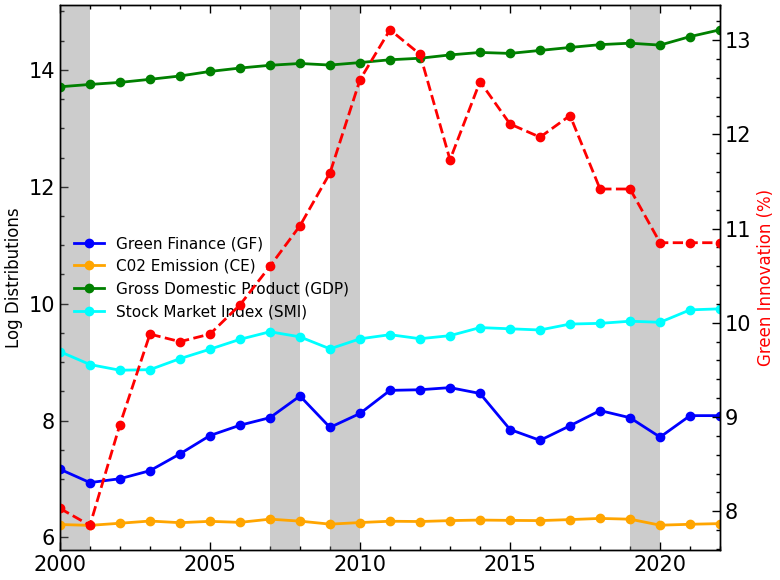

<Figure size 3600x2400 with 0 Axes>

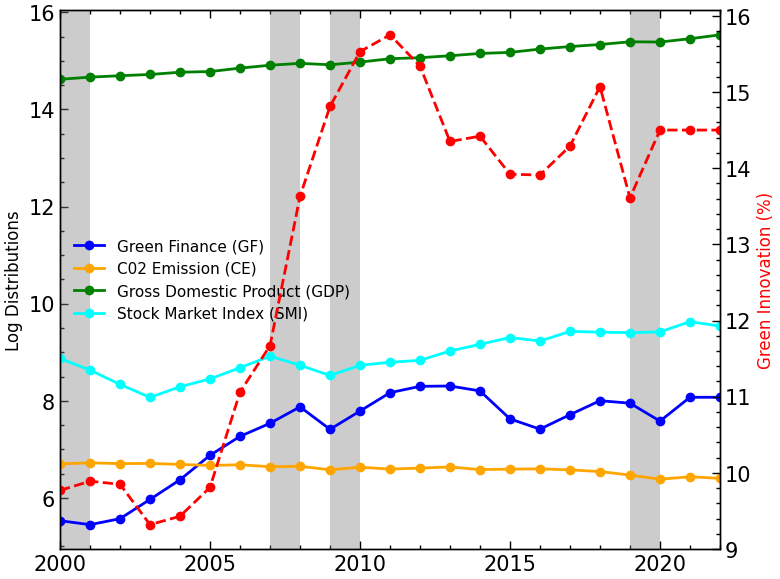

<Figure size 3600x2400 with 0 Axes>

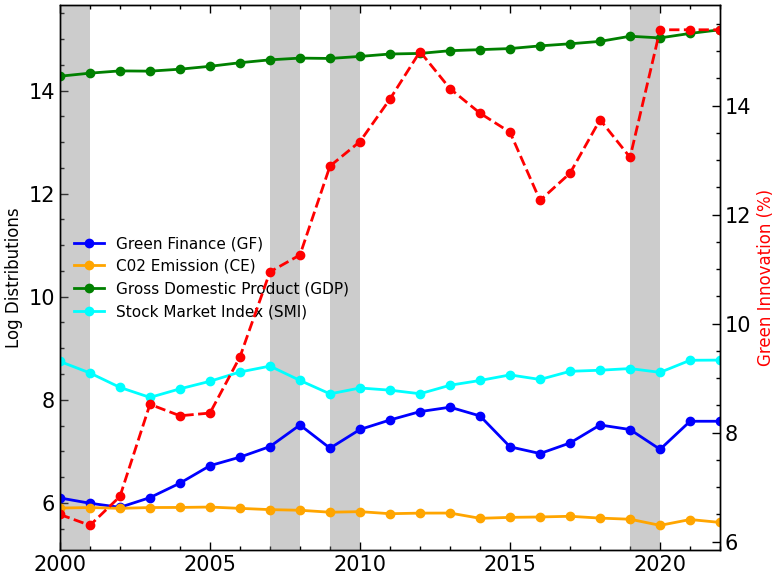

<Figure size 3600x2400 with 0 Axes>

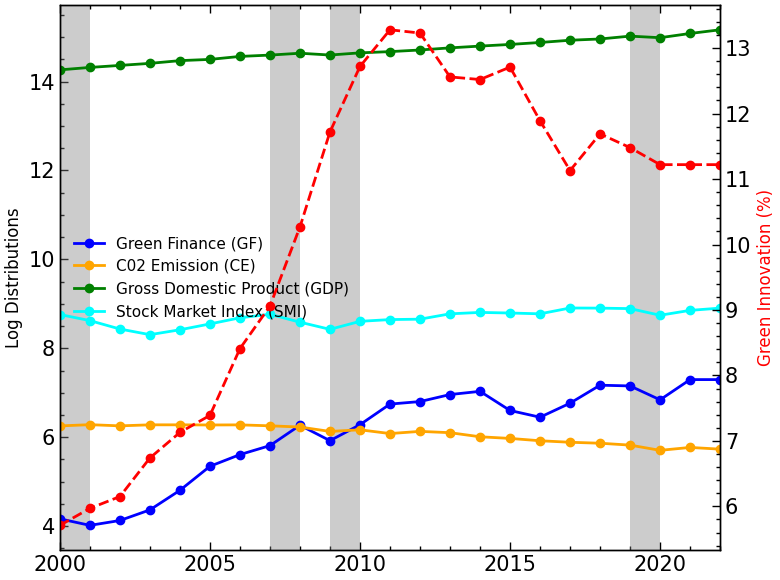

<Figure size 3600x2400 with 0 Axes>

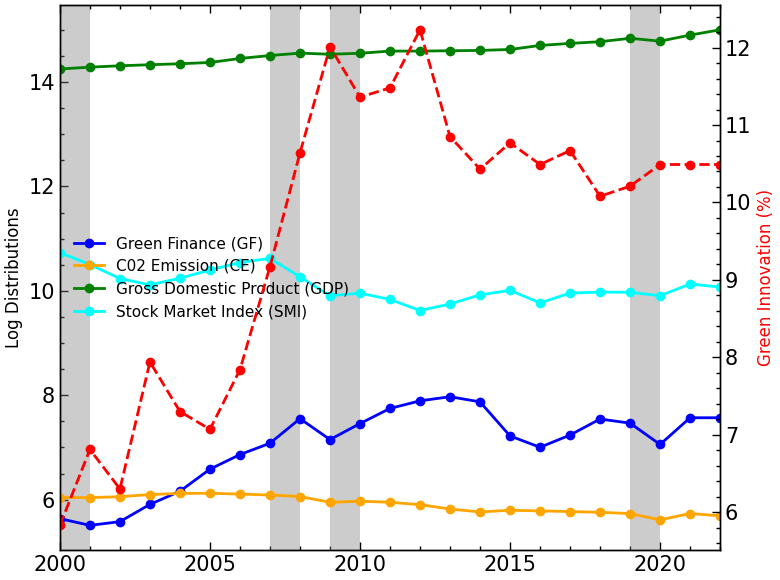

<Figure size 3600x2400 with 0 Axes>

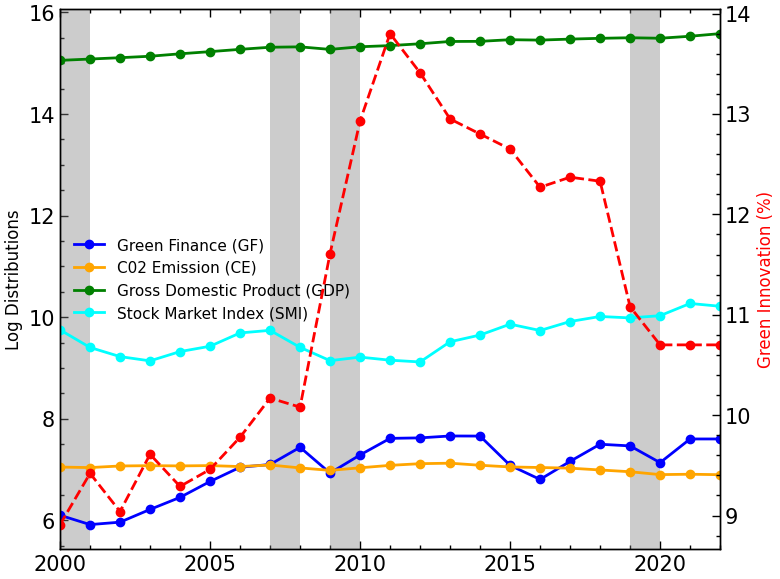

<Figure size 3600x2400 with 0 Axes>

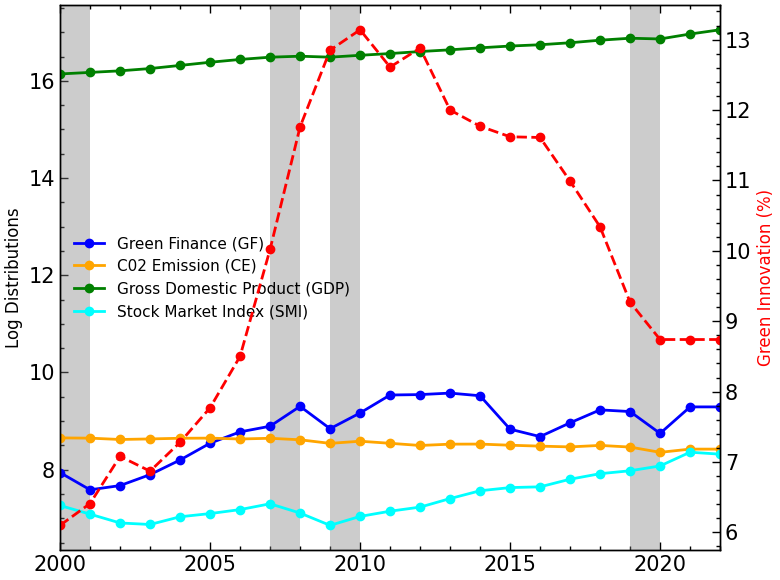

<Figure size 3600x2400 with 0 Axes>

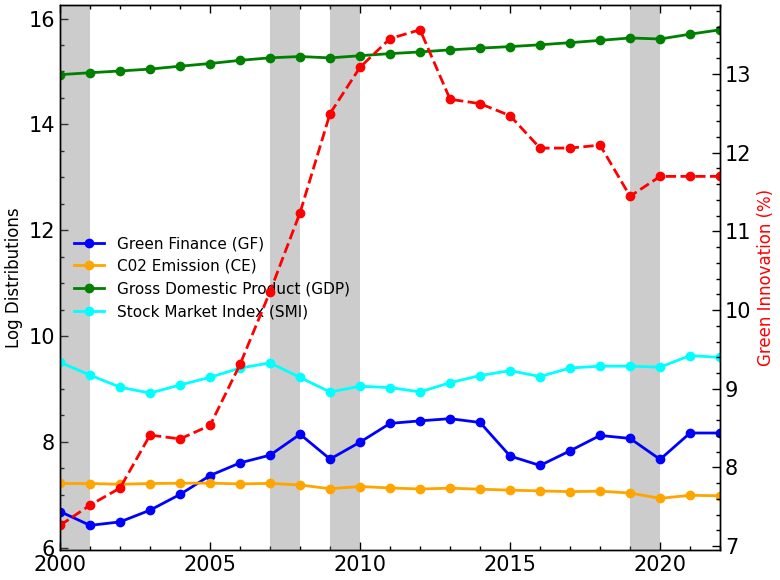

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# od ='/kaggle/working/plots'

# if not os.path.exists(od):
#     os.makedirs(od)
    
for country in df_graph['location'].unique():
    
    # Assuming df_sent_vars is your DataFrame with the necessary columns

    plt.style.use(['science', 'notebook', 'grid'])
    plt.figure(figsize=(12, 8), dpi=300)
    # # Plot with two y-axes
    fig, ax = plt.subplots()
    # fig.patch.set_facecolor('white')
    # ax.set_facecolor('white')

    # Use the DataFrame's plot method directly for better readability
    np.log(df_graph[df_graph['location']== country].iloc[:,[2,8,10,15]]).plot(linestyle ='-', marker ='o',color = ['blue', 'orange', 'green', 'cyan'], label=['Renewable Financing','Stock Market'], ax=ax)
    df_graph[df_graph['location']== country].iloc[:,[3]].plot(linestyle ='--', marker ='o', color = ['red'],secondary_y=True, ax=ax)

    # Enable LaTeX rendering
    # plt.rcParams['text.usetex'] = True

    # Set labels for both y-axes
    ax.set_ylabel('Log Distributions', color='black', fontsize=12)
    ax.right_ax.set_ylabel('Green Innovation (%)', fontsize=12, color='red')
    ax.set_xlabel("", fontsize=12)
    
   # Set the title for the subplot
#     ax.set_title(f'Key Variables of {country}', fontsize=14)


    # shaded regions
    x_dotcom_b = "2000-12-31"
    x_dotcom_e = "2001-10-31"
    x_gfc_b = "2007-12-31"
    x_gfc_e = "2008-12-31"
    x_esdc_b = "2009-12-31"
    x_esdc_e = "2010-12-31"
    x_covid_b = "2019-12-31"
    x_covid_e = "2020-04-30"

    # Shade regions
    ax.axvspan(x_dotcom_b, x_dotcom_e, facecolor='gray', alpha=0.4, label='Dotcom')
    ax.axvspan(x_gfc_b, x_gfc_e, facecolor='gray', alpha=0.4, label='GFC')
    ax.axvspan(x_esdc_b, x_esdc_e, facecolor='gray', alpha=0.4, label='ESDC')
    ax.axvspan(x_covid_b, x_covid_e, facecolor='gray', alpha=0.4, label='COVID-19')

    # Customize the grid
    ax.grid(True, linestyle='', alpha=0.8)
    # Show only the legend for 'Y1'
    ax.legend(loc = 'center left',labels=['Green Finance (GF)','C02 Emission (CE)',"Gross Domestic Product (GDP)",'Stock Market Index (SMI)'], fontsize = 11, framealpha=0)


    # Set x-axis ticks at 3-year intervals
#     ax.xaxis.set_major_locator(mdates.YearLocator(base=4))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Adjust the format as needed

    # Reduce font size of tick labels on both axes
    ax.tick_params(axis='both', which='both', labelsize=15)
    ax.right_ax.tick_params(axis='both', which='both', labelsize=15)

    # Use tight_layout for better spacing
    plt.tight_layout()

#     saving the graph in the Drive folder
    graph_name = f'plot_{country}.png'
    plt.savefig(graph_name)

    plt.show()


## Separating the data and individual level analysis

In [43]:
# 'CAN', 'DEU', 'FRA', 'GBR', 'ITA', 'JPN', 'USA', and 'G7 AVERAGE'

df_can = df_graph[df_graph['location']=='CAN']
df_deu = df_graph[df_graph['location']=='DEU']
df_fra = df_graph[df_graph['location']=='FRA']
df_gbr = df_graph[df_graph['location']=='GBR']
df_ita = df_graph[df_graph['location']=='ITA']
df_jpn = df_graph[df_graph['location']=='JPN']
df_usa = df_graph[df_graph['location']=='USA']
df_g7 = df_graph[df_graph['location']=='G7 AVERAGE']


## G7 Average Plots of the key Variables


<Figure size 3600x2400 with 0 Axes>

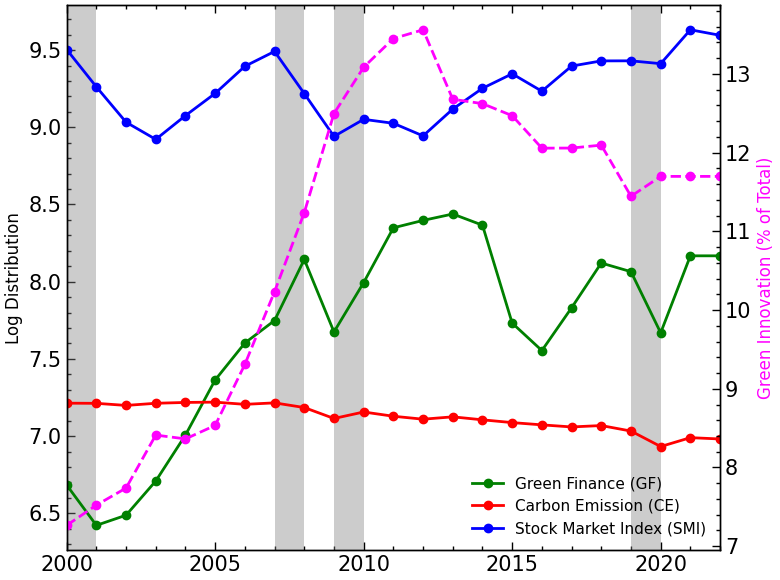

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df_sent_vars is your DataFrame with the necessary columns

plt.style.use(['science', 'notebook', 'grid'])
plt.figure(figsize=(12, 8), dpi=300)
# # Plot with two y-axes
fig, ax = plt.subplots()
# fig.patch.set_facecolor('white')
# ax.set_facecolor('white')

# Use the DataFrame's plot method directly for better readability
np.log(df_g7.iloc[:,[2,8,15]]).plot(linestyle ='-', marker ='o',color = ['green','red','blue'], ax=ax)
df_g7.iloc[:,[3]].plot(linestyle ='--', marker ='o', color = 'magenta',secondary_y=True, ax=ax)

# Enable LaTeX rendering
# plt.rcParams['text.usetex'] = True

# Set labels for both y-axes
ax.set_ylabel('Log Distribution', color='black', fontsize=12)
ax.right_ax.set_ylabel('Green Innovation (% of Total)', fontsize=12, color='magenta')
ax.set_xlabel("", fontsize=12)

# Set the title for the subplot
# ax.set_title("G7 (Average)", fontsize=14)

# shaded regions
x_dotcom_b = "2000-12-31"
x_dotcom_e = "2001-10-31"
x_gfc_b = "2007-12-31"
x_gfc_e = "2008-12-31"
x_esdc_b = "2009-12-31"
x_esdc_e = "2010-12-31"
x_covid_b = "2019-12-31"
x_covid_e = "2020-04-30"

# Shade regions
ax.axvspan(x_dotcom_b, x_dotcom_e, facecolor='gray', alpha=0.4, label='Dotcom')
ax.axvspan(x_gfc_b, x_gfc_e, facecolor='gray', alpha=0.4, label='GFC')
ax.axvspan(x_esdc_b, x_esdc_e, facecolor='gray', alpha=0.4, label='ESDC')
ax.axvspan(x_covid_b, x_covid_e, facecolor='gray', alpha=0.4, label='COVID-19')

# Customize the grid
ax.grid(True, linestyle='', alpha=0.8)
# Show only the legend for 'Y1'
ax.legend(loc = 'lower right',labels=['Green Finance (GF)','Carbon Emission (CE)','Stock Market Index (SMI)'], fontsize = 11, framealpha=0)


# Set x-axis ticks at 3-year intervals
# ax.xaxis.set_major_locator(mdates.YearLocator(base=4))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Adjust the format as needed

# Reduce font size of tick labels on both axes
ax.tick_params(axis='both', which='both', labelsize=15)
ax.right_ax.tick_params(axis='both', which='both', labelsize=15)

# Use tight_layout for better spacing
plt.tight_layout()

# saving the graph in the Drive folder
plt.savefig('/kaggle/working/1.G7.png')

plt.show()


## DEU Plots of the key Variables

<Figure size 3600x2400 with 0 Axes>

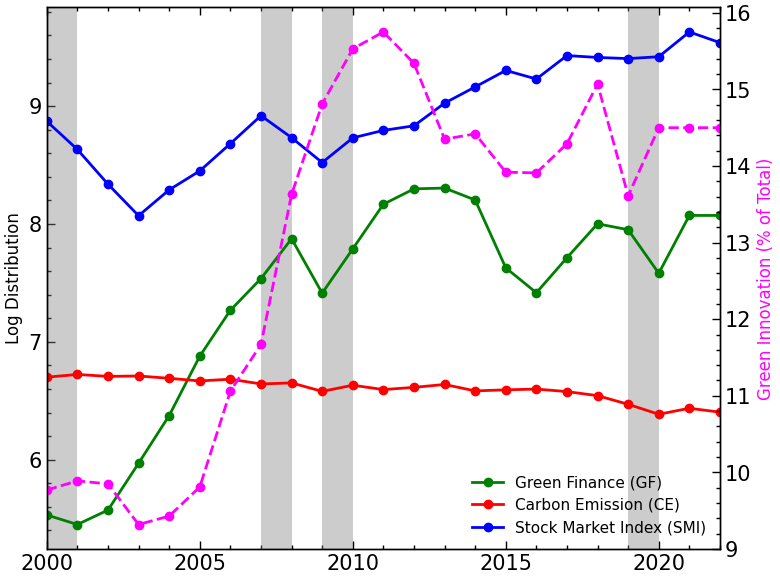

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df_sent_vars is your DataFrame with the necessary columns

plt.style.use(['science', 'notebook', 'grid'])
plt.figure(figsize=(12, 8), dpi=300)
# # Plot with two y-axes
fig, ax = plt.subplots()
# fig.patch.set_facecolor('white')
# ax.set_facecolor('white')

# Use the DataFrame's plot method directly for better readability
np.log(df_deu.iloc[:,[2,8,15]]).plot(linestyle ='-', marker ='o',color = ['green','red','blue'], ax=ax)
df_deu.iloc[:,[3]].plot(linestyle ='--', marker ='o', color = 'magenta',secondary_y=True, ax=ax)

# Enable LaTeX rendering
# plt.rcParams['text.usetex'] = True

# Set labels for both y-axes
ax.set_ylabel('Log Distribution', color='black', fontsize=12)
ax.right_ax.set_ylabel('Green Innovation (% of Total)', fontsize=12, color='magenta')
ax.set_xlabel("", fontsize=12)

# Set the title for the subplot
# ax.set_title("Germany", fontsize=14)

# shaded regions
x_dotcom_b = "2000-12-31"
x_dotcom_e = "2001-10-31"
x_gfc_b = "2007-12-31"
x_gfc_e = "2008-12-31"
x_esdc_b = "2009-12-31"
x_esdc_e = "2010-12-31"
x_covid_b = "2019-12-31"
x_covid_e = "2020-04-30"

# Shade regions
ax.axvspan(x_dotcom_b, x_dotcom_e, facecolor='gray', alpha=0.4, label='Dotcom')
ax.axvspan(x_gfc_b, x_gfc_e, facecolor='gray', alpha=0.4, label='GFC')
ax.axvspan(x_esdc_b, x_esdc_e, facecolor='gray', alpha=0.4, label='ESDC')
ax.axvspan(x_covid_b, x_covid_e, facecolor='gray', alpha=0.4, label='COVID-19')

# Customize the grid
ax.grid(True, linestyle='', alpha=0.8)
# Show only the legend for 'Y1'
ax.legend(loc = 'lower right',labels=['Green Finance (GF)','Carbon Emission (CE)','Stock Market Index (SMI)'], fontsize = 11, framealpha=0)


# Set x-axis ticks at 3-year intervals
# ax.xaxis.set_major_locator(mdates.YearLocator(base=4))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Adjust the format as needed

# Reduce font size of tick labels on both axes
ax.tick_params(axis='both', which='both', labelsize=15)
ax.right_ax.tick_params(axis='both', which='both', labelsize=15)

# Use tight_layout for better spacing
plt.tight_layout()

# saving the graph in the Drive folder
plt.savefig('/kaggle/working/2.Germany.png')

plt.show()


## Stationarity test in the data 

In [46]:
# Creating df based on stationary data
# germany
df1_deu = np.log(df_deu.iloc[:,[2,8,15]].div(df_deu.iloc[:,[2,8,15]].shift(1))).dropna()
df2_deu = df1_deu.iloc[:,[0]].diff()
df_st_deu = pd.concat([df1_deu.iloc[1:,1:],df2_deu,df_deu.iloc[1:,[3]].div(100)], axis = 1).fillna(0)
df_st_deu = df_st_deu.mul(100)
df_st_deu.rename(columns = {'rec_mill_usd':'GF','env_pat_pc_tot':'GI','co2_mln_tonne':'CE','stock_index':'SMR'}, inplace =True)


# g7 average
df_st_g7 = np.log(df_g7.iloc[:,[2,3,8,15]].div(df_g7.iloc[:,[2,3,8,15]].shift(1))).mul(100).dropna()
df_st_g7.rename(columns = {'rec_mill_usd':'GF','env_pat_pc_tot':'GI','co2_mln_tonne':'CE','stock_index':'SMR'}, inplace =True)


# Vector Autoregression (VAR) analysis

### Germany

Selected lag order: 1


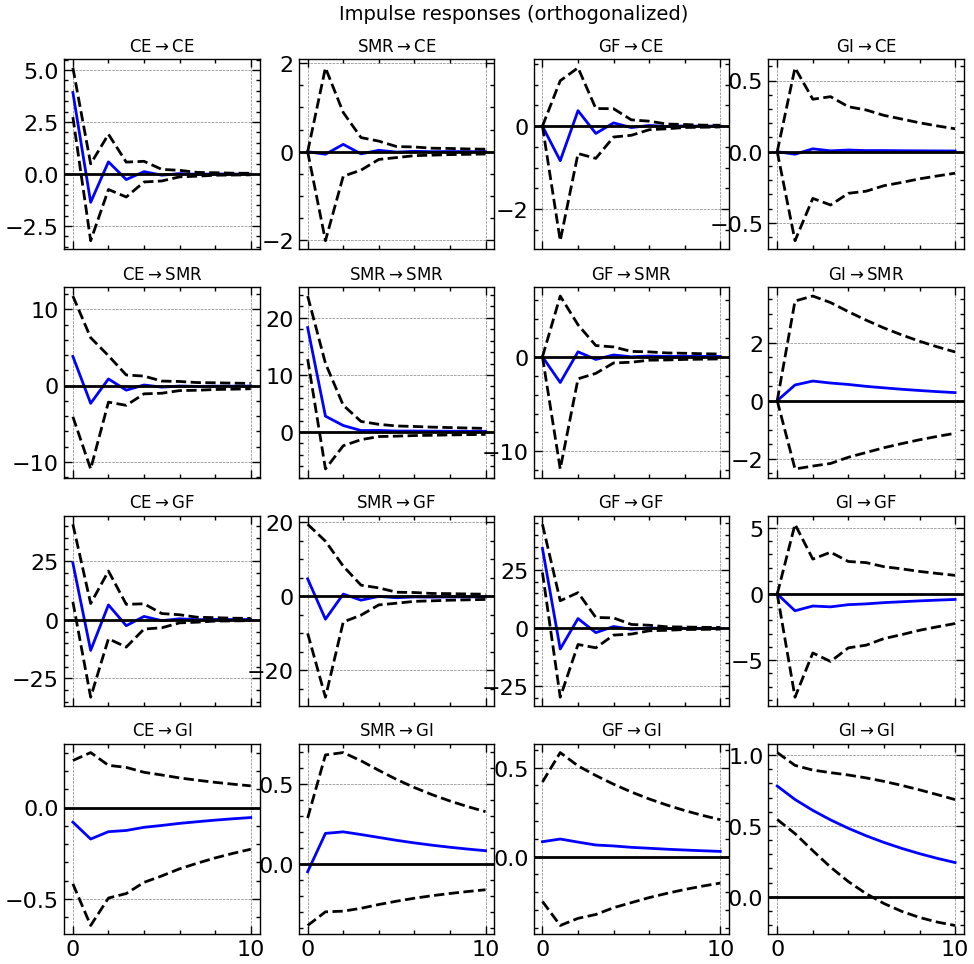

In [47]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Model Specification
model = sm.tsa.VAR(df_st_deu)

# optimal lag order
optimal_lag = model.select_order()
selected_lag = optimal_lag.selected_orders['aic']  # Use 'aic' or other criteria if needed

# Print the selected lag order
print(f"Selected lag order: {selected_lag}")

# Model fitting
var_model = model.fit(selected_lag)

# Plotting irf
irf = var_model.irf(periods=10)  # Adjust the number of periods as needed
irf.plot(orth=True)
plt.savefig('/kaggle/working/2.Germany_irf.png')
plt.show()


In [48]:
# Granger Causalty test
causality_test = var_model.test_causality('CE', ['GI',"GF",'SMR'], kind='f') # variable to test, causing variable 
print(causality_test.summary())

Granger causality F-test. H_0: ['GI', 'GF', 'SMR'] do not Granger-cause CE. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.2432          2.748   0.866 (3, 64)
---------------------------------------------


### G7 average

Selected lag order: 3


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)


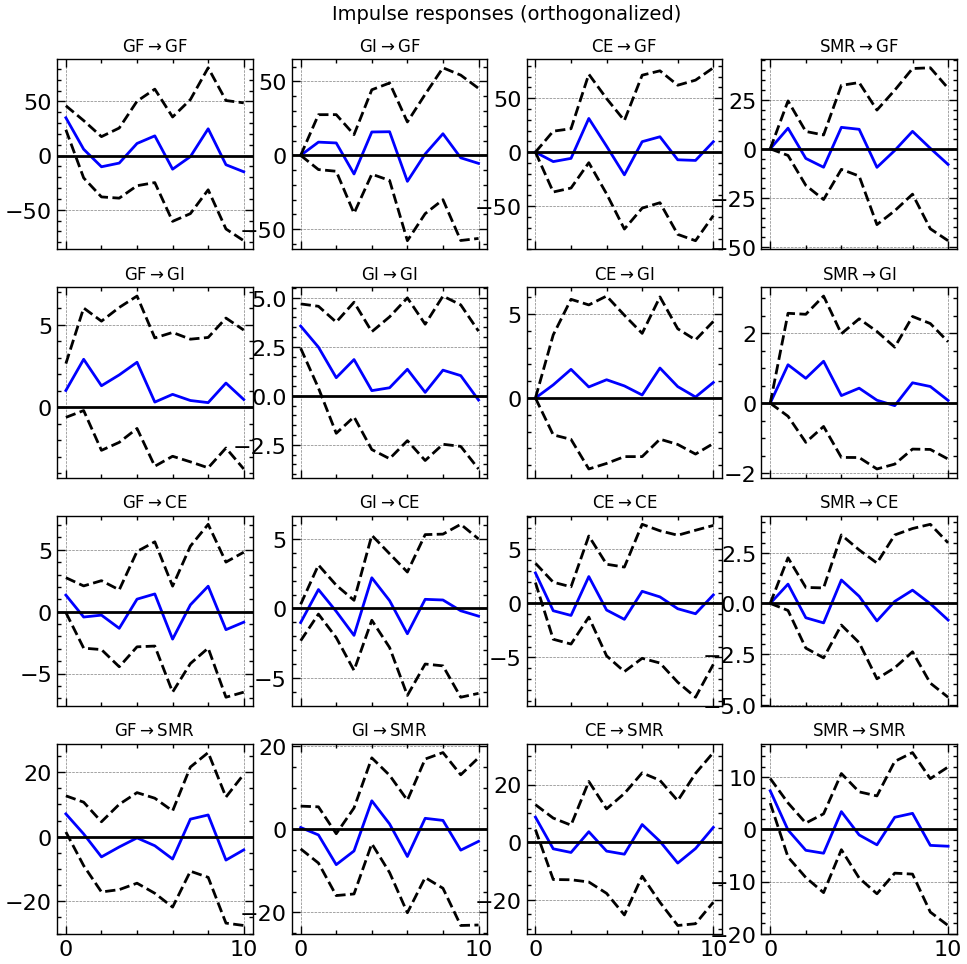

In [49]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Model Specification
model = sm.tsa.VAR(df_st_g7)

# optimal lag order
optimal_lag = model.select_order()
selected_lag = optimal_lag.selected_orders['aic']  # Use 'aic' or other criteria if needed

# Print the selected lag order
print(f"Selected lag order: {selected_lag}")

# Model fitting
var_model = model.fit(selected_lag)

# Plotting irf
irf = var_model.irf(periods=10)  # Adjust the number of periods as needed
irf.plot(orth=True)
plt.savefig('/kaggle/working/2.g7_irf.png')
plt.show()

In [50]:
# Granger Causalty test
causality_test = var_model.test_causality('CE', ['GI','GF','SMR'], kind='f') # variable to test, causing variable 
print(causality_test.summary())

Granger causality F-test. H_0: ['GI', 'GF', 'SMR'] do not Granger-cause CE. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.9648          2.300   0.492 (9, 24)
---------------------------------------------


# Regression Analysis (Linear not Panel)

### Using Dep. of CE (DEU)

In [51]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# x-variables along with the models (model 1)

model1 = sm.OLS.from_formula('CE ~ GI + 1', data=df_st_deu).fit()
model2 = sm.OLS.from_formula('CE ~ GI + GF + 1', data=df_st_deu).fit()
model3 = sm.OLS.from_formula('CE ~ GI + GF + SMR + 1', data=df_st_deu).fit()
model4 = sm.OLS.from_formula('CE ~ GI + GF + SMR + GI*GF + 1', data=df_st_deu).fit()

# printing the results in more cleaner way
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer

# Assuming model1, model2, ..., model6 are your regression models
stargazer = Stargazer([model1,model2,model3,model4])

# Display the HTML table in Jupyter Notebook
HTML(stargazer.render_html())

# Save the HTML to a file
with open('/kaggle/working/regression_results_ce_deu.html', 'w') as file:
    file.write(stargazer.render_html())

### Using Dep. of SMR (DEU)

In [52]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# x-variables along with the models (model 1)

model1 = sm.OLS.from_formula('SMR ~ GI + 1', data=df_st_deu).fit()
model2 = sm.OLS.from_formula('SMR ~ GI + GF + 1', data=df_st_deu).fit()
model3 = sm.OLS.from_formula('SMR ~ GI + GF + CE + 1', data=df_st_deu).fit()
model4 = sm.OLS.from_formula('SMR ~ GI + GF + CE + GI*GF + 1', data=df_st_deu).fit()

# printing the results in more cleaner way
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer

# Assuming model1, model2, ..., model6 are your regression models
stargazer = Stargazer([model1,model2,model3,model4])

# Display the HTML table in Jupyter Notebook
HTML(stargazer.render_html())

# Save the HTML to a file
with open('/kaggle/working/regression_results_smr_deu.html', 'w') as file:
    file.write(stargazer.render_html())

### Using Dep. of CE (G7)

In [53]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# x-variables along with the models (model 1)

model1 = sm.OLS.from_formula('CE ~ GI + 1', data=df_st_g7).fit()
model2 = sm.OLS.from_formula('CE ~ GI + GF + 1', data=df_st_g7).fit()
model3 = sm.OLS.from_formula('CE ~ GI + GF + SMR + 1', data=df_st_g7).fit()
model4 = sm.OLS.from_formula('CE ~ GI + GF + SMR + GI*GF + 1', data=df_st_g7).fit()

# printing the results in more cleaner way
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer

# Assuming model1, model2, ..., model6 are your regression models
stargazer = Stargazer([model1,model2,model3,model4])

# Display the HTML table in Jupyter Notebook
HTML(stargazer.render_html())

# Save the HTML to a file
with open('/kaggle/working/regression_results_ce_g7.html', 'w') as file:
    file.write(stargazer.render_html())

### Using Dep. of SMR (G7)

In [54]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# x-variables along with the models (model 1)

model1 = sm.OLS.from_formula('SMR ~ GI + 1', data=df_st_g7).fit()
model2 = sm.OLS.from_formula('SMR ~ GI + GF + 1', data=df_st_g7).fit()
model3 = sm.OLS.from_formula('SMR ~ GI + GF + CE + 1', data=df_st_g7).fit()
model4 = sm.OLS.from_formula('SMR ~ GI + GF + CE + GI*GF + 1', data=df_st_g7).fit()

# printing the results in more cleaner way
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer

# Assuming model1, model2, ..., model6 are your regression models
stargazer = Stargazer([model1,model2,model3,model4])

# Display the HTML table in Jupyter Notebook
HTML(stargazer.render_html())

# Save the HTML to a file
with open('/kaggle/working/regression_results_smr_g7.html', 'w') as file:
    file.write(stargazer.render_html())

## Correlation matrix and Heatmap (full)

In [55]:
corr_mat = df_graph.iloc[:,[1,2,3,5,8,9,10,11,12,14]]
# corr_mat.columns

In [56]:
corr_mat = corr_mat.rename(columns = {'exprt_pc_gdp':'EXPRT (PCGDP)', 'rec_mill_usd':'GF (MUSD)', 'env_pat_pc_tot':'GI (PCT)', 'unr_pc_lf':'UNEMPR (PCLF)',
                           'co2_mln_tonne':'CE (MT)', 'term_trade_rt':'TT (IND)', 'gdp_mln_usd':'GDP (MUSD)', 'envtx_pc_gdp':'ENVTXR (PCGDP)',
                           'govt_borr_pc_gdp':'GOVBR (PCGDP)', 'stock_returns':"SMR"})

# corr_mat.drop(columns =['GDP (MUSD)','ENVTXR (PCGDP)', 'GOVBR (PCGDP)', 'EXPRT (PCGDP)','CE (MT)', 'SMR'], inplace = True)
# corr_mat.drop(columns =['ENVTXR (PCGDP)', 'GOVBR (PCGDP)', 'EXPRT (PCGDP)','CE (MT)', 'SMR'], inplace = True)
# corr_mat.drop(columns =['CE (MT)','SMR'], inplace = True)

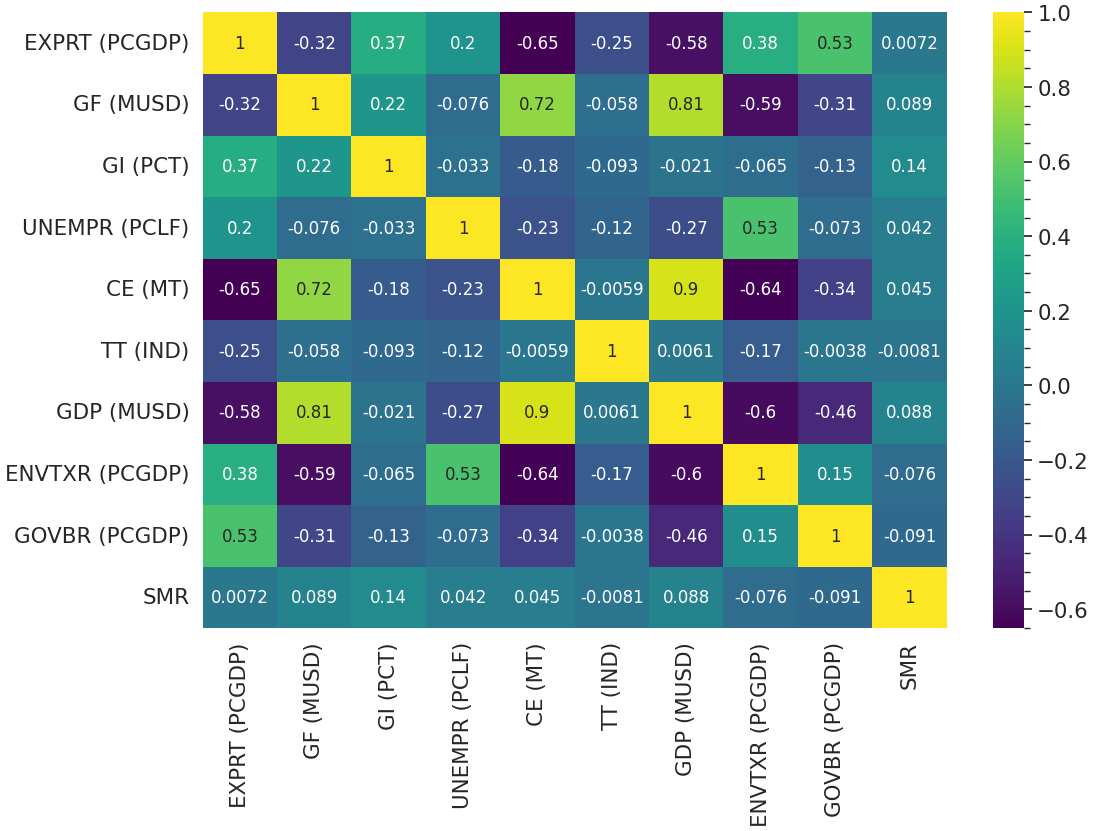

In [57]:
# Correlation heatmaps
import seaborn as sns
plt.figure(figsize = (12,8))
sns.set(font_scale =1.4)
sns.heatmap(corr_mat.corr(), cmap = "viridis", annot = True, annot_kws = {"size":12})
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.savefig('Correlation_heatmap_0.png') 
plt.show()

## Correlation Matrix (After dropping highly correlated variables)

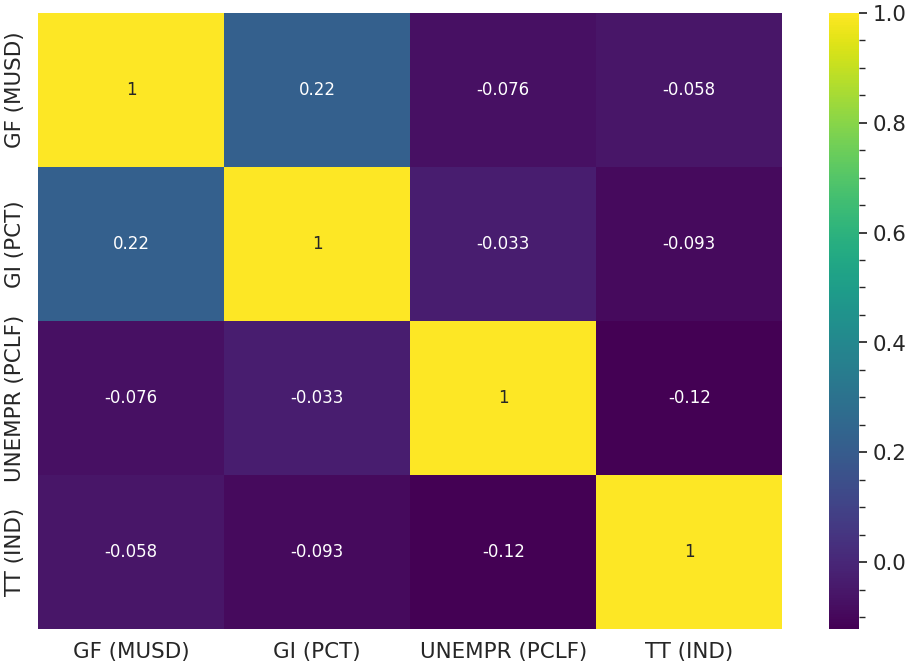

In [58]:
corr_mat = corr_mat.rename(columns = {'exprt_pc_gdp':'EXPRT (PCGDP)', 'rec_mill_usd':'GF (MUSD)', 'env_pat_pc_tot':'GI (PCT)', 'unr_pc_lf':'UNEMPR (PCLF)',
                           'co2_mln_tonne':'CE (MT)', 'term_trade_rt':'TT (IND)', 'gdp_mln_usd':'GDP (MUSD)', 'envtx_pc_gdp':'ENVTXR (PCGDP)',
                           'govt_borr_pc_gdp':'GOVBR (PCGDP)', 'stock_returns':"SMR"})

corr_mat.drop(columns =['GDP (MUSD)','ENVTXR (PCGDP)', 'GOVBR (PCGDP)', 'EXPRT (PCGDP)','CE (MT)', 'SMR'], inplace = True)

# Correlation heatmaps
import seaborn as sns
plt.figure(figsize = (12,8))
sns.set(font_scale =1.4)
sns.heatmap(corr_mat.corr(), cmap = "viridis", annot = True, annot_kws = {"size":12})
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.savefig('Correlation_heatmap_1.png') 
plt.show()

## VIF

In [59]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming corr_mat is your DataFrame and it contains only predictor variables.

# Note: Directly use corr_mat without adding a constant term for the intercept.
X = np.log(corr_mat)  # No add_constant here

# Create a DataFrame to hold VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [60]:
# # Create a QQ plot of the residuals
# fig, ax = plt.subplots(figsize=(12, 8))
# sm.qqplot(model.resid, line='s', ax=ax)  # 's' line represents a standardized normal distribution
# ax.set_title('QQ Plot of Residuals')
# plt.show()

In [61]:
# residuals = model.resid

# # Conduct the Shapiro-Wilk test for normality
# shapiro_test_statistic, shapiro_p_value = stats.shapiro(residuals)

# # Print the test statistic and p-value
# print("Shapiro-Wilk Test Statistic:", shapiro_test_statistic)
# print("P-Value:", shapiro_p_value)

# # Interpret the results
# alpha = 0.05  # Set your significance level
# if shapiro_p_value > alpha:
#     print("The residuals appear to be normally distributed (Fail to reject the null hypothesis).")
# else:
#     print("The residuals do not appear to be normally distributed (Reject the null hypothesis).")


### Quantile regression .... Later!

In [62]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# # Create a QuantReg model
# quantile_model = smf.quantreg('CE ~ GI + GF + SMR + 1', data=df_st_deu)

# # Specify the quantile (e.g., 0.5 for median)
# quantile = 0.75

# # Fit the quantile regression model
# quantile_result = quantile_model.fit(q=quantile)

# # View the results summary
# print(quantile_result.summary())

# # Make predictions for a specific quantile
# predictions = quantile_result.predict(df_st_deu)
# print(predictions)